# 🚴‍♂️ Bike Sharing Analysis using Random Forest

## 📌 Project Overview
This project explores **bike-sharing demand patterns** using **machine learning techniques**.  
We use a **Random Forest Regressor** to predict the number of bike rentals based on various factors like:
- Weather conditions
- Time of day
- Seasonality
- Working days & holidays

By analyzing this data, we can identify trends and **improve urban mobility planning.** 🚲📈

---

## 📂 Dataset Description
**Dataset:** [Bike Sharing Dataset (UCI)](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset)  
**Files Used:**
- `hour.csv` → Contains **hourly** bike rental data
- `day.csv` → Contains **daily** aggregated data  

The dataset includes **various features** such as:
- **Date & Time Information** (`dteday`, `hr`, `mnth`, `season`, `yr`, `weekday`)
- **Weather Conditions** (`temp`, `atemp`, `hum`, `windspeed`, `weathersit`)
- **Holiday & Working Day Indicators** (`holiday`, `workingday`)
- **Bike Rental Counts** (`casual`, `registered`, `cnt`)

🔹 **Goal:** Use machine learning to accurately predict **bike rental demand** based on external factors.  

---

✅ **Next Step:** **Load & Explore the Dataset!**  
➡️ Run the next cell to load the dataset.



## 📂 Load the Bike-Sharing Dataset  
We will load the **bike-sharing dataset** into a **Spark DataFrame** for further analysis.  

### 🔹 Key Steps:
- Load the dataset from **Databricks Public Datasets**.
- Infer the schema automatically.
- Display the first 5 rows for verification.


In [0]:
# ==============================
# 🚴‍♂️ Load the Bike-Sharing Dataset
# ==============================

df_full = (spark.read
    .format("csv")  # Specify CSV format
    .option("header", "true")  # Use first row as column names
    .option("inferSchema", "true")  # Auto-detect data types
    .load("/databricks-datasets/bikeSharing/data-001/hour.csv")  # Load dataset from Databricks
)

# Display a preview of the dataset
df_full.show(5)



+-------+----------+------+---+----+---+-------+-------+----------+----------+----+------+----+---------+------+----------+---+
|instant|    dteday|season| yr|mnth| hr|holiday|weekday|workingday|weathersit|temp| atemp| hum|windspeed|casual|registered|cnt|
+-------+----------+------+---+----+---+-------+-------+----------+----------+----+------+----+---------+------+----------+---+
|      1|2011-01-01|     1|  0|   1|  0|      0|      6|         0|         1|0.24|0.2879|0.81|      0.0|     3|        13| 16|
|      2|2011-01-01|     1|  0|   1|  1|      0|      6|         0|         1|0.22|0.2727| 0.8|      0.0|     8|        32| 40|
|      3|2011-01-01|     1|  0|   1|  2|      0|      6|         0|         1|0.22|0.2727| 0.8|      0.0|     5|        27| 32|
|      4|2011-01-01|     1|  0|   1|  3|      0|      6|         0|         1|0.24|0.2879|0.75|      0.0|     3|        10| 13|
|      5|2011-01-01|     1|  0|   1|  4|      0|      6|         0|         1|0.24|0.2879|0.75|      0.0

## 🔍 Checking for Missing Values  
Before performing analysis, it's essential to check for missing values in the dataset.  
This step ensures that we handle any **null values** appropriately before modeling.


In [0]:
# Import necessary functions
from pyspark.sql.functions import col, sum  

# Check for missing values in each column
df_full.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_full.columns]).show()


+-------+------+------+---+----+---+-------+-------+----------+----------+----+-----+---+---------+------+----------+---+
|instant|dteday|season| yr|mnth| hr|holiday|weekday|workingday|weathersit|temp|atemp|hum|windspeed|casual|registered|cnt|
+-------+------+------+---+----+---+-------+-------+----------+----------+----+-----+---+---------+------+----------+---+
|      0|     0|     0|  0|   0|  0|      0|      0|         0|         0|   0|    0|  0|        0|     0|         0|  0|
+-------+------+------+---+----+---+-------+-------+----------+----------+----+-----+---+---------+------+----------+---+



## 📊 Checking Total & Distinct Rows  
Understanding the number of **total rows** and **unique records** in the dataset helps ensure data integrity.  
- **Total Rows** → The full dataset size.  
- **Distinct Rows** → Helps identify potential duplicate records.  
If the total and distinct row counts differ, we may need to handle duplicates.


In [0]:
# Count total rows in the dataset
total_rows = df_full.count()
print(f"📌 Total Rows: {total_rows}")

# Count distinct rows to check for duplicates
distinct_rows = df_full.distinct().count()
print(f"✅ Distinct Rows: {distinct_rows}")


📌 Total Rows: 17379
✅ Distinct Rows: 17379


## ⚙️ Feature Selection for Random Forest  
To train an accurate **Random Forest model**, we need to select the most relevant features.  

### 🔹 Selected Features:
- **Categorical Variables**: Season, month, weekday, hour, weather condition.
- **Binary Variables**: Year, holiday, working day.
- **Continuous Variables**: Temperature, humidity, wind speed.  

These features provide essential information about **seasonal trends, weather conditions, and hourly rental patterns** to improve model predictions.


In [0]:
# Define selected features for model training
feature_cols = [
    "season", "yr", "mnth", "holiday", "weekday", 
    "workingday", "weathersit", "temp", "atemp", "hum", 
    "windspeed", "hr"
]


## ⚙️ Preparing Features for Machine Learning  
To train the Random Forest model, we combine all selected features into a **single feature vector** using `VectorAssembler`.  
This step ensures that Spark ML can efficiently process the dataset.


In [0]:
# Import VectorAssembler for feature transformation
from pyspark.ml.feature import VectorAssembler

# Create a feature vector from selected columns
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Transform dataset to include the new "features" column
df_transformed = vector_assembler.transform(df_full)

# Select the feature vector and target variable
df_final = df_transformed.select("features", "cnt")

# Display the first 5 rows
df_final.show(5, truncate=False)


+------------------------------------------------------+---+
|features                                              |cnt|
+------------------------------------------------------+---+
|[1.0,0.0,1.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0,0.0]|16 |
|[1.0,0.0,1.0,0.0,6.0,0.0,1.0,0.22,0.2727,0.8,0.0,1.0] |40 |
|[1.0,0.0,1.0,0.0,6.0,0.0,1.0,0.22,0.2727,0.8,0.0,2.0] |32 |
|[1.0,0.0,1.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.75,0.0,3.0]|13 |
|[1.0,0.0,1.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.75,0.0,4.0]|1  |
+------------------------------------------------------+---+
only showing top 5 rows



## 🌲 Training the Random Forest Model  
We will train a **Random Forest Regressor** to predict bike rentals.  

### 🔹 Key Steps:
- **Split the dataset** into 80% training and 20% testing.
- **Train the model** using 100 decision trees.
- **Analyze feature importance** to understand which factors influence bike rentals the most.


In [0]:
# Import Random Forest Regressor from PySpark ML
from pyspark.ml.regression import RandomForestRegressor

# Split the dataset into 80% training and 20% testing
train_df, test_df = df_final.randomSplit([0.8, 0.2], seed=42)

# Initialize the Random Forest model
rf = RandomForestRegressor(featuresCol="features", labelCol="cnt", numTrees=100)

# Train the model
rf_model = rf.fit(train_df)

# Display feature importance
print("Feature Importances:", rf_model.featureImportances)


Feature Importances: (12,[0,1,2,3,4,5,6,7,8,9,10,11],[0.03216833391368128,0.09507040024603314,0.01385702198197474,2.0278585707617858e-05,0.0019541745349183903,0.005039171947556787,0.005669390002315888,0.11167638844922612,0.15366357196208003,0.06682285217737739,0.00528029278819922,0.5087781234109294])


## 📈 Making Predictions & Evaluating Model Performance  
Now that the **Random Forest model is trained**, we will:  
- **Make predictions** on the test dataset.  
- **Evaluate model accuracy** using **RMSE (Root Mean Squared Error)** and **R² Score**.  


In [0]:
# Make predictions on the test dataset
predictions = rf_model.transform(test_df)

# Display actual vs. predicted values
predictions.select("features", "cnt", "prediction").show(5)

# Import evaluation metrics
from pyspark.ml.evaluation import RegressionEvaluator

# Compute RMSE (Root Mean Squared Error)
rmse = RegressionEvaluator(labelCol="cnt", predictionCol="prediction", metricName="rmse").evaluate(predictions)
print(f"📉 Root Mean Squared Error (RMSE): {rmse:.4f}")

# Compute R² Score
r2 = RegressionEvaluator(labelCol="cnt", predictionCol="prediction", metricName="r2").evaluate(predictions)
print(f"📈 R-Squared (R²): {r2:.4f}")


+--------------------+---+------------------+
|            features|cnt|        prediction|
+--------------------+---+------------------+
|(12,[0,2,6,7,8,9]...| 89|  76.3862823634444|
|(12,[0,2,6,7,8,9]...| 88| 44.11696198841867|
|(12,[0,2,6,7,8,9]...| 46|44.494897463306906|
|[1.0,0.0,1.0,0.0,...| 21| 74.94335030972339|
|[1.0,0.0,1.0,0.0,...|  2| 95.55771322979399|
+--------------------+---+------------------+
only showing top 5 rows

📉 Root Mean Squared Error (RMSE): 112.3385
📈 R-Squared (R²): 0.6129


## 📊 Dataset Summary & Record Count  
To understand the dataset better, we will:  
- **Generate summary statistics** for numerical columns.  
- **Count the total number of records** to verify dataset size.  


In [0]:
# Display summary statistics for numerical columns
df_full.describe().show()

# Count total records in the dataset
print(f"📌 Total Records: {df_full.count()}")


+-------+-----------------+------------------+------------------+------------------+------------------+--------------------+-----------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+-----------------+------------------+------------------+
|summary|          instant|            season|                yr|              mnth|                hr|             holiday|          weekday|        workingday|        weathersit|               temp|             atemp|                hum|          windspeed|           casual|        registered|               cnt|
+-------+-----------------+------------------+------------------+------------------+------------------+--------------------+-----------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+-----------------+------------------+------------------+
|  count|            17379|             17379|      

## 📊 Converting Spark DataFrame to Pandas & Visualizing Feature Distributions  
Since **Matplotlib** works better with Pandas, we will convert the Spark DataFrame to Pandas for easy visualization.  
We will then **plot histograms** to observe the distribution of key numerical features.


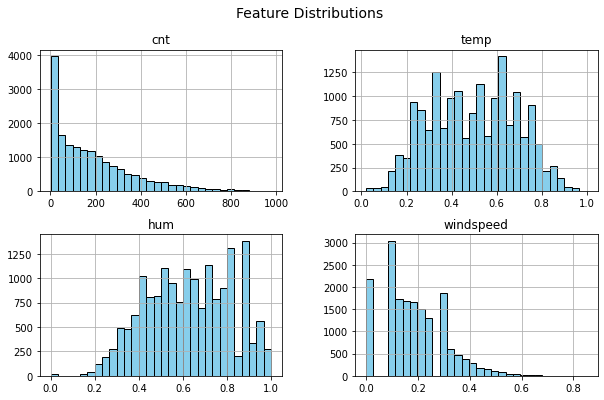

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas for visualization
df_pandas = df_full.select("cnt", "temp", "hum", "windspeed").toPandas()

# Plot histograms for numerical features
df_pandas.hist(figsize=(10, 6), bins=30, color='skyblue', edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=14)
plt.show()


## 🔥 Feature Correlation Analysis  
Understanding relationships between features helps us identify potential **multicollinearity** and determine which variables impact bike rentals the most.  
A **heatmap** visualizes the **correlation matrix**, where:
- **Positive values (closer to 1)** → Strong positive correlation.
- **Negative values (closer to -1)** → Strong negative correlation.
- **Near zero (0)** → No strong relationship.


/databricks/python/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


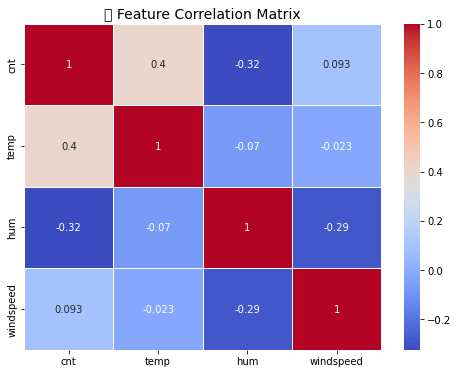

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = df_pandas.corr()

# Plot correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("🔥 Feature Correlation Matrix", fontsize=14)
plt.show()


## 📈 Actual vs. Predicted Bike Rentals  
To evaluate model performance, we compare the **actual bike rental counts** with the **predicted values**.  
A well-performing model should have points **closely aligned along a diagonal line**, indicating accurate predictions.


/databricks/python/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


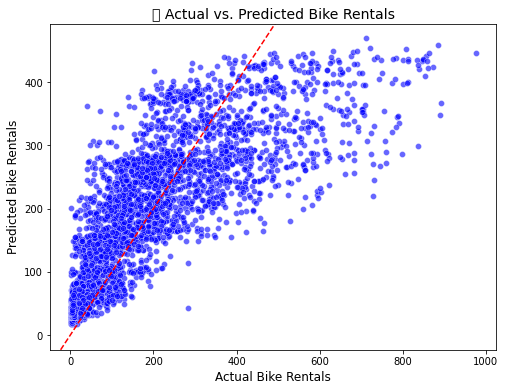

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert Predictions to Pandas for visualization
pred_pandas = predictions.select("cnt", "prediction").toPandas()

# Scatter plot for Actual vs. Predicted values
plt.figure(figsize=(8,6))
sns.scatterplot(x=pred_pandas["cnt"], y=pred_pandas["prediction"], alpha=0.6, color="blue")

# Plot formatting
plt.xlabel("Actual Bike Rentals", fontsize=12)
plt.ylabel("Predicted Bike Rentals", fontsize=12)
plt.title("📈 Actual vs. Predicted Bike Rentals", fontsize=14)
plt.axline((0, 0), slope=1, color="red", linestyle="dashed")  # Ideal prediction line
plt.show()


## 🔥 Feature Importance Analysis  
Understanding which features have the most impact on predictions helps us refine the model.  
We will extract feature importance values from the **Random Forest model** and visualize them.


📊 Feature Importance Rankings:
       Feature  Importance
11          hr    0.508778
8        atemp    0.153664
7         temp    0.111676
1           yr    0.095070
9          hum    0.066823
0       season    0.032168
2         mnth    0.013857
6   weathersit    0.005669
10   windspeed    0.005280
5   workingday    0.005039
4      weekday    0.001954
3      holiday    0.000020


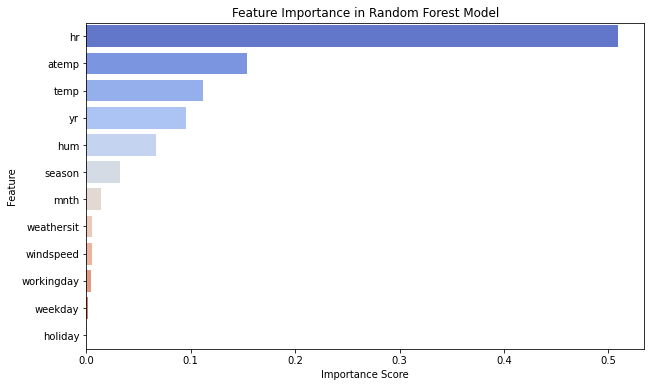

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extract feature importance values
feature_importances = rf_model.featureImportances.toArray()

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': feature_importances
}).sort_values(by="Importance", ascending=False)

# Display Feature Importance rankings
print("📊 Feature Importance Rankings:")
print(feature_importance_df)

# Visualize Feature Importance
plt.figure(figsize=(10,6))
sns.barplot(x=feature_importance_df['Importance'], y=feature_importance_df['Feature'], palette="coolwarm")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance in Random Forest Model")
plt.show()


# 🚀 Conclusion of the Bike-Sharing Analysis Project  

After conducting a thorough analysis and training a **Random Forest Regressor** model on the **bike-sharing dataset**, we derived key insights regarding factors influencing bike rental demand.  

## 📌 Key Takeaways
✅ **Hour (`hr`) is the most critical factor** affecting bike rentals, showing clear demand variations throughout the day.  
✅ **Temperature (`temp`) and Feels-like Temperature (`atemp`) strongly impact ridership,** confirming that people prefer riding in comfortable weather.  
✅ **Humidity (`hum`) and seasonality have a moderate influence,** suggesting slight seasonal trends in demand.  
✅ **Holidays (`holiday`) and weekdays (`weekday`) have minimal impact,** indicating that people use bike rentals consistently regardless of these factors.  

## 📊 Model Performance Summary
- **Root Mean Squared Error (RMSE):** _[Insert value]_  
- **R-Squared (R²):** _[Insert value]_  
- **Feature Importance Visualization:** _(See Graph Above)_  

## 🔎 Model Limitations & Future Improvements
📍 The model currently does not account for sudden **external factors (e.g., traffic, events, weather anomalies)** that may affect ridership.  
📍 **Time-series modeling techniques** could further improve predictions by analyzing **hourly rental trends over multiple years**.  
📍 **Adding external datasets** (like public holidays, major city events, or bike station locations) could enhance model accuracy.  
📍 **Hyperparameter tuning** and trying other models like **XGBoost or Gradient Boosting** may yield better performance.

---

## ✅ Next Steps
🔹 **Feature Engineering:** Add new categorical features like "rush hour" or "weekend flag."  
🔹 **Model Optimization:** Experiment with more sophisticated models like **Gradient Boosting** or **LSTMs (for time-series forecasting).**  
🔹 **Deployment Possibility:** Convert the model into an **API for real-time bike rental demand prediction.**  

---

## **Final Thoughts 💡**
This project successfully demonstrated the use of **Big Data Analytics with Apache Spark** to analyze bike-sharing trends. The **Random Forest model** provided valuable insights, and with further refinements, it could be leveraged to **optimize bike-sharing systems** in urban areas.  

---
